<img src = 'fotos/logo_dani.jpeg'>

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import itertools
import pickle

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, HalvingGridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import tpot
from tpot import TPOTRegressor

from IPython.display import clear_output
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

C:\Users\unito\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## Ficheros y rutas de entrada/salida 

In [2]:
dir_in = '../../datos/datos_desarrollo'
file1_in = 'consumo_final.csv'
dir_out = dir_in

## Carga de datos 

In [3]:
df_consumo = pd.read_csv(os.path.join(dir_in, file1_in), sep = ';')
df_consumo.columns = [columna.lower() for columna in df_consumo.columns]
df_consumo.rename(columns = {'fecha_inicio': 'mes_inicio_temp', 'fecha_fin': 'mes_fin_temp'}, inplace = True)
df_consumo.date = pd.to_datetime(df_consumo.date, format = '%Y-%m-%d')
precio_model = df_consumo[['ccaa', 'producto', 'volumen_miles_de_kg', 'valor_miles_de_€', 'precio_medio_kg', 'date']]

<AxesSubplot:>

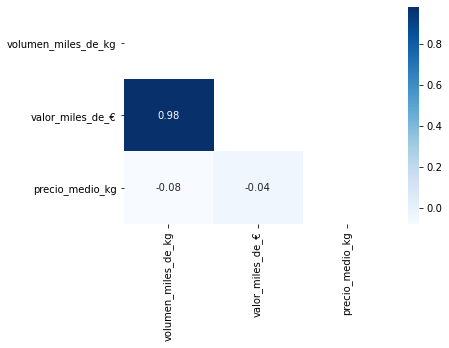

In [4]:
corr_df = precio_model.corr()
corr_df = round(corr_df, 2)
mask_ut = np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask = mask_ut, cmap = 'Blues', annot = True)

## CATBOOST

### Partición de los datos (catboost)

In [ ]:
regress_model_dict = {product: precio_model[(precio_model.producto == product) & (precio_model.date < '2020-03-01')]\
                      .drop(columns = ['date', 'producto']) for product in precio_model.producto.unique()}

X = np.delete(regress_model_dict['Patatas'].values, 2, axis = 1)
Y = regress_model_dict['Patatas'].values[:, 2]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 
scaler = MinMaxScaler().fit(X_train[:, 1:])
xtr_scaled = scaler.transform(X_train[:, 1:])
xte_scaled = scaler.transform(X_test[:, 1:])
xtr_final = np.concatenate((X_train[:, 0].reshape(-1, 1), xtr_scaled), axis = 1)
xte_final = np.concatenate((X_test[:, 0].reshape(-1, 1), xte_scaled), axis = 1)

In [ ]:
def modelaje(xtr, ytr, categorical_indices_features, model, param_grid, score):
    try:
        modelo = model(random_state = 0, silent = True, cat_features = categorical_indices_features)
    except:
        modelo = model(random_state = 0)
    if len(param_grid) == 0:
        cv = cross_val_score(estimator = model, cv = 10, scoring = score, X = xtr, y = ytr, n_jobs = 4, random_state = 0).mean()
        best_model = model.fit(xtr, ytr)
        best_score = cv
        best_params = 'Default'
    else:
        gscv = HalvingGridSearchCV(estimator = modelo, param_grid = param_grid, cv = 10, scoring = score, random_state = 0).fit(xtr, ytr)
        best_model = gscv.best_estimator_
        best_score = gscv.best_score_ 
        best_params = gscv.best_params_
        sd_cv = np.std(cross_val_score(estimator = best_model, X = xtr, y = ytr, scoring = score, cv = 10))
    
    return best_model, best_score, best_params, sd_cv

In [ ]:
param_grid = {'task_type': ['GPU']}
best_model_CAT, best_score_CAT, best_params_CAT, sd_cv_CAT = modelaje(xtr_final, Y_train, [0], CatBoostRegressor, param_grid, 'r2')

In [ ]:
ypred = best_model_CAT.predict(X_test)
mean_absolute_error(Y_test, ypred)

## TPOT 

### Partición de los datos 

In [20]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(precio_model[['ccaa']])
dummy_ccaa = pd.DataFrame(encoder.transform(precio_model[['ccaa']]).toarray())
dummy_ccaa.columns = encoder.get_feature_names(['ccaa'])
precio_model_dummy = pd.concat([precio_model, pd.DataFrame(dummy_ccaa)], axis = 1).drop(columns = 'ccaa')

In [23]:
regress_model_dict_dummy = {product: precio_model_dummy[(precio_model_dummy.producto == product) & 
                                                        (precio_model_dummy.date < '2020-03-01')]\
                      .drop(columns = ['date', 'producto']) for product in precio_model_dummy.producto.unique()}

X = np.delete(regress_model_dict_dummy['Patatas'].values, 2, axis = 1)
Y = regress_model_dict_dummy['Patatas'].values[:, 2]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 

In [ ]:
model1 = TPOTRegressor(generations=5, population_size=50, cv=10, scoring='r2', verbosity=2, random_state=0, n_jobs=10)
model1.fit(X_train, Y_train)

In [ ]:
ypred1 = model1.predict(X_test)
r2_score(Y_test, ypred1)

## Predicciones 

In [39]:
periodo_covid_patatas = precio_model_dummy[(precio_model_dummy.producto == 'Patatas') & (precio_model_dummy.date >= '2020-03-01')]
periodo_covid_patatas.drop(columns = ['producto', 'date'], inplace = True)

,volumen_miles_de_kg,valor_miles_de_€,precio_medio_kg,ccaa_Andalucia,ccaa_Aragon,ccaa_Asturias,ccaa_Baleares,ccaa_Canarias,ccaa_Cantabria,ccaa_Castilla la mancha,...,ccaa_Cataluña,ccaa_Extremadura,ccaa_Galicia,ccaa_La rioja,ccaa_Madrid,ccaa_Murcia,ccaa_Nacional,ccaa_Navarra,ccaa_Pais vasco,ccaa_Valencia
468,144056.38,137944.62,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
469,26781.88,25208.52,0.94,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
470,3242.56,3119.75,0.96,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,3981.23,3218.15,0.81,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472,3868.96,4070.38,1.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
